In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from dlomix.losses import masked_spectral_distance, masked_pearson_correlation_distance
from dlomix.data import FragmentIonIntensityDataset

import os

2024-11-08 21:35:07.663322: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-08 21:35:07.729612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 21:35:07.729664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 21:35:07.733654: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 21:35:07.748473: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-08 21:35:07.750164: I tensorflow/core/platform/cpu_feature_guard.cc:1


Avaliable feature extractors are (use the key of the following dict and pass it to features_to_extract in the Dataset Class):
{
   "atom_count": "Atom count of PTM.",
   "delta_mass": "Delta mass of PTM.",
   "mod_gain": "Gain of atoms due to PTM.",
   "mod_loss": "Loss of atoms due to PTM.",
   "red_smiles": "Reduced SMILES representation of PTM."
}.
When writing your own feature extractor, you can either
    (1) use the FeatureExtractor class or
    (2) write a function that can be mapped to the Hugging Face dataset.
In both cases, you can access the parsed sequence information from the dataset using the following keys, which all provide python lists:
    - _parsed_sequence: parsed sequence
    - _n_term_mods: N-terminal modifications
    - _c_term_mods: C-terminal modifications



In [2]:
model_names = [
    "b_r_token_mult_d5_static_0.0005_Ff7",
    "b_r_token_sum_d5_static_0.0005_ONf",
    "b_r_FiLM_full_d5_static_0.0005_fLL",
    "b_r_single_both_d5_static_0.0005_f8a",
    "b_r_penult_mult_d5_static_0.0005_1ou",
    "b_r_penult_sum_d5_static_0.0005_ucY",
    "b_r_embed_input_d5_static_0.0005_2yL",
    "b_r_single_token_d5_static_0.0005_x1c",
    "b_r_multi_token_d5_static_0.0005_6Jr",
]

model_labels = [name.split('_r_')[1].split('_d5_')[0] for name in model_names]
model_labels = [
    "Multiple Mult",
    "Multiple Sum",
    "FiLM Integration",
    "Simple Integration",
    "Penultimate Mult",
    "Penultimate Sum",
    "Embed Channel",
    "Embed Single Token",
    "Embed Multi Token",
]

custom_palette = {
    "Multiple Mult"        : "#d0bbff",
    "Multiple Sum"         : "#d0bbff",
    "FiLM Integration"     : "#d0bbff",
    "Simple Integration"   : "#d0bbff",
    "Penultimate Mult"     : "#ff9f9b",
    "Penultimate Sum"      : "#ff9f9b",
    "Embed Channel"        : "#a1c9f4",
    "Embed Single Token"   : "#a1c9f4",
    "Embed Multi Token"    : "#a1c9f4",
}

In [5]:
print(model_names[5])

model = keras.saving.load_model('/cmnfs/proj/prosit_astral/saved_models/final_models/%s.keras' % model_names[5],
                                custom_objects={'masked_spectral_distance': masked_spectral_distance, 'masked_pearson_correlation_distance': masked_pearson_correlation_distance}, 
                                compile=True, safe_mode=True)
model.summary()


print(len(int_data.tensor_train_data))
print(len(int_data.tensor_val_data))

f_r_FiLM_full_d5_static_0.0005_XOr
Model: "transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  6656      
                                                                 
 dense_1 (Dense)             multiple                  3328      
                                                                 
 dense_2 (Dense)             multiple                  657920    
                                                                 
 trans_block (TransBlock)    multiple                  524545    
                                                                 
 trans_block_1 (TransBlock)  multiple                  524545    
                                                                 
 trans_block_2 (TransBlock)  multiple                  524545    
                                                                 
 trans_block_3

NameError: name 'int_data' is not defined

In [3]:
int_data = FragmentIonIntensityDataset.load_from_disk("/nfs/home/students/d.lochert/projects/astral/dlomix-astral/balanced_dataset")

In [4]:
losses = []

eval_batches = [m for m in int_data.tensor_val_data.take(10)]

for model_name in model_names:

    model = keras.saving.load_model('/cmnfs/proj/prosit_astral/saved_models/final_models/%s.keras' % model_name,
                                custom_objects={'masked_spectral_distance': masked_spectral_distance, 'masked_pearson_correlation_distance': masked_pearson_correlation_distance}, 
                                compile=True, safe_mode=True)
    
    pred = []
    true = []
    
    for j in range(0, len(eval_batches)):
    
        predictions = model.predict(eval_batches[j][0], verbose=0)
    
        pred += np.split(predictions,        predictions.shape[0], axis=0) 
        true += np.split(eval_batches[j][1], predictions.shape[0], axis=0) 
    
    pred = np.concatenate(pred, axis=0)
    true = np.concatenate(true, axis=0)
    
    print('Loss: ', tf.reduce_mean( masked_spectral_distance(true, pred) ))

    losses.append(masked_spectral_distance(true, pred))

print(losses)

Loss:  tf.Tensor(0.16627295, shape=(), dtype=float32)
Loss:  tf.Tensor(0.16793215, shape=(), dtype=float32)
Loss:  tf.Tensor(0.1688875, shape=(), dtype=float32)
Loss:  tf.Tensor(0.16582906, shape=(), dtype=float32)
Loss:  tf.Tensor(0.17331219, shape=(), dtype=float32)
Loss:  tf.Tensor(0.18069929, shape=(), dtype=float32)
Loss:  tf.Tensor(0.17041385, shape=(), dtype=float32)
Loss:  tf.Tensor(0.16824651, shape=(), dtype=float32)
Loss:  tf.Tensor(0.16663939, shape=(), dtype=float32)
[<tf.Tensor: shape=(10240,), dtype=float32, numpy=
array([0.06766787, 0.08972914, 0.05634351, ..., 0.13859491, 0.40697008,
       0.13458948], dtype=float32)>, <tf.Tensor: shape=(10240,), dtype=float32, numpy=
array([0.06838408, 0.08400123, 0.05400253, ..., 0.10678549, 0.4293702 ,
       0.17010482], dtype=float32)>, <tf.Tensor: shape=(10240,), dtype=float32, numpy=
array([0.09252137, 0.1222348 , 0.05596014, ..., 0.15712738, 0.43004996,
       0.15499522], dtype=float32)>, <tf.Tensor: shape=(10240,), dtype=flo

In [5]:
import pandas as pd
import numpy as np

print(len(np.repeat(model_labels, len(losses[0]))))
print(len(tf.concat(losses, axis=0)))

for i in losses:
    print(len(i))


test = pd.DataFrame({
    'method': np.repeat(model_labels, len(losses[0])),
    'loss': 1 - tf.concat(losses, axis=0),
})

test.groupby('method')['loss'].median()

92160
92160
10240
10240
10240
10240
10240
10240
10240
10240
10240


method
Embed Channel         0.860255
Embed Multi Token     0.864388
Embed Single Token    0.862388
FiLM Integration      0.862215
Multiple Mult         0.864516
Multiple Sum          0.862856
Penultimate Mult      0.857527
Penultimate Sum       0.849092
Simple Integration    0.865726
Name: loss, dtype: float32

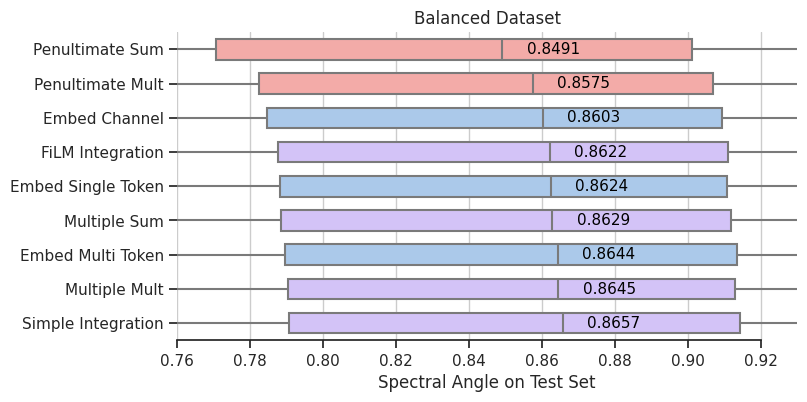

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis and set the plot size
f, ax = plt.subplots(figsize=(8, 4))  # Adjust the size here

ax.set_xlim(0.76, .93)

method_order = test.groupby('method')['loss'].median().sort_values().index

# sns.violinplot(
#     test, x="loss", y="method",
#     order=method_order, palette=custom_palette
# )

sns.boxplot(
   test, x="loss", y="method",
   order=method_order,  # Order y-axis by median loss
   whis=[0, 100], 
   width=.6, palette=custom_palette
)

# Calculate and label the medians
medians = test.groupby('method')['loss'].median().reindex(method_order)

for i, method in enumerate(method_order):
    median_value = medians[method]
    ax.text(median_value+0.014, i, f'{median_value:.4f}', 
            va='center', ha='center', color='black', size=11)

# Add in points to show each observation
# sns.stripplot(test, x="loss", y="method", order=method_order, size=4, color=".3")

start_patch = mpatches.Patch(color="#a1c9f4", label='Start of Model')
block_patch = mpatches.Patch(color="#d0bbff", label='Transformer Block')
end_patch = mpatches.Patch(color="#ff9f9b", label='End of Model')

# plt.legend(handles=[start_patch, block_patch, end_patch], bbox_to_anchor=(1, 0.92))

plt.xlabel('Spectral Angle on Test Set')
plt.title('Balanced Dataset')

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

plt.show()